In [846]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [847]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [848]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2359557 entries, 0 to 2359556
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.0 MB


# reduce to 1 million events

In [849]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [850]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,31296,0.12,31.296
1,32085,0.11,32.085
2,32854,0.11,32.854
3,32819,0.11,32.819
4,32716,0.11,32.716
...,...,...,...
999995,28700,0.12,28.700
999996,29674,0.12,29.674
999997,28220,0.13,28.220
999998,27532,0.13,27.532


### conversion Interval -> kWh

In [851]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,31296,0.12,31.296,115.030675
1,32085,0.11,32.085,112.201964
2,32854,0.11,32.854,109.575699
3,32819,0.11,32.819,109.692556
4,32716,0.11,32.716,110.037902
...,...,...,...,...
999995,28700,0.12,28.700,125.435540
999996,29674,0.12,29.674,121.318326
999997,28220,0.13,28.220,127.569100
999998,27532,0.13,27.532,130.756937


### Cumul Total interval

In [852]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [853]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26959194511000

### Calcul de la date de base = now - cumul_interval

In [854]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 26, 7, 32, 51, 547871)

In [855]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [856]:
conso_data.iloc[0]


Interval     31296.000000
kWh              0.120000
sec             31.296000
Wh             115.030675
cumul(ms)    31296.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [857]:
base

datetime.datetime(2024, 8, 26, 7, 32, 51, 547871)

## créer les dates

In [858]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-26 07:33:22.843871
1        2024-08-26 07:33:54.928871
2        2024-08-26 07:34:27.782871
3        2024-08-26 07:35:00.601871
4        2024-08-26 07:35:33.317871
                    ...            
999995   2025-07-04 08:10:54.405871
999996   2025-07-04 08:11:24.079871
999997   2025-07-04 08:11:52.299871
999998   2025-07-04 08:12:19.831871
999999   2025-07-04 08:12:46.058871
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [859]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,31296,0.12,31.296,115.030675,31296,2024-08-26 07:33:22.843871,26/08/24
1,32085,0.11,32.085,112.201964,63381,2024-08-26 07:33:54.928871,26/08/24
2,32854,0.11,32.854,109.575699,96235,2024-08-26 07:34:27.782871,26/08/24
3,32819,0.11,32.819,109.692556,129054,2024-08-26 07:35:00.601871,26/08/24
4,32716,0.11,32.716,110.037902,161770,2024-08-26 07:35:33.317871,26/08/24
...,...,...,...,...,...,...,...
999995,28700,0.12,28.700,125.435540,26959082858,2025-07-04 08:10:54.405871,04/07/25
999996,29674,0.12,29.674,121.318326,26959112532,2025-07-04 08:11:24.079871,04/07/25
999997,28220,0.13,28.220,127.569100,26959140752,2025-07-04 08:11:52.299871,04/07/25
999998,27532,0.13,27.532,130.756937,26959168284,2025-07-04 08:12:19.831871,04/07/25


### save conso_data with dates

In [860]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [861]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('04/07/25', 4, 7, 2025, '08:13:00')

In [862]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [863]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 999124 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   876 non-null    int64         
 1   kWh        876 non-null    float64       
 2   sec        876 non-null    float64       
 3   Wh         876 non-null    float64       
 4   cumul(ms)  876 non-null    int64         
 5   dates      876 non-null    datetime64[ns]
 6   days       876 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 54.8+ KB


In [864]:
end = time.time()
print(end - start)

18.626152992248535


### grouped by days

In [865]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [866]:
data = list(df_grp['kWh'])
print(data)

[2.448, 3.936, 3.76, 4.045, 3.603, 3.704, 3.539, 3.632, 3.513, 4.141, 3.527, 3.662, 3.585, 3.155, 2.605, 1.798, 1.793, 1.795, 1.794, 2.425, 1.913, 1.787, 1.793, 1.788, 1.82, 1.82, 1.817, 1.815, 1.818, 1.817, 1.815, 1.818, 1.784, 1.787, 1.785, 1.785, 1.783, 1.798, 1.787, 1.791, 1.784, 1.794, 1.802, 1.796, 1.8, 1.8, 1.785, 1.788, 1.787, 1.79, 1.797, 1.79, 1.8, 1.804, 1.793, 1.801, 1.799, 2.664, 4.0, 3.674, 3.903, 3.099, 3.385, 4.098, 3.387, 3.46, 4.009, 3.329, 3.723, 3.576, 3.982, 3.199, 3.313, 3.421, 4.077, 3.28, 3.382, 3.823, 3.225, 3.555, 3.295, 3.906, 3.352, 3.43, 3.734, 4.419, 3.604, 3.861, 3.4, 4.181, 3.505, 3.436, 3.308, 3.848, 3.685, 4.119, 3.21, 3.743, 3.787, 3.172, 3.68, 3.665, 3.37, 3.883, 3.189, 4.072, 3.43, 3.738, 4.049, 3.412, 4.528, 3.254, 3.48, 3.097, 3.212, 3.443, 3.352, 3.401, 3.449, 4.634, 4.516, 3.235, 3.441, 3.65, 3.951, 3.523, 4.452, 4.176, 4.118, 3.746, 3.766, 3.522, 3.542, 4.384, 3.17, 3.374, 3.396, 3.451, 3.61, 3.381, 4.557, 3.261, 3.789, 3.243, 3.685, 3.451, 3.3

In [867]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [868]:
end = time.time()
print(end - start)

19.218738079071045


### plot function by day
#### show('dd/mm/yy')

In [869]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


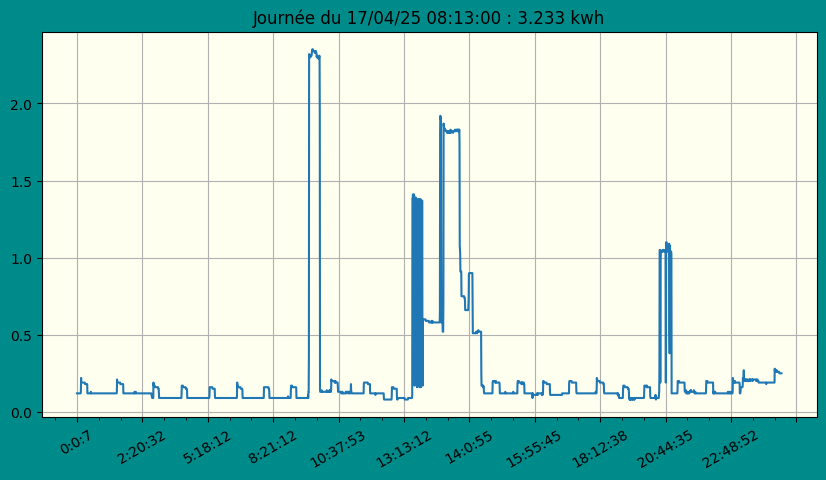

In [870]:
show('17/04/25')

In [871]:
end = time.time()
print(end - start)

20.21705985069275


### 1 kWh window in data of one day
#### df = conso_day

In [872]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999124,22656,0.16,22.656,158.898305,26929639469,2025-07-04 00:00:11.016871,04/07/25
999125,37942,0.09,37.942,94.881661,26929677411,2025-07-04 00:00:48.958871,04/07/25
999126,37391,0.10,37.391,96.279853,26929714802,2025-07-04 00:01:26.349871,04/07/25
999127,37067,0.10,37.067,97.121429,26929751869,2025-07-04 00:02:03.416871,04/07/25
999128,39118,0.09,39.118,92.029245,26929790987,2025-07-04 00:02:42.534871,04/07/25
...,...,...,...,...,...,...,...
999995,28700,0.12,28.700,125.435540,26959082858,2025-07-04 08:10:54.405871,04/07/25
999996,29674,0.12,29.674,121.318326,26959112532,2025-07-04 08:11:24.079871,04/07/25
999997,28220,0.13,28.220,127.569100,26959140752,2025-07-04 08:11:52.299871,04/07/25
999998,27532,0.13,27.532,130.756937,26959168284,2025-07-04 08:12:19.831871,04/07/25


In [873]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [874]:
df = conso_day
len(df)

876

In [875]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-04 00:00:11.016871	2025-07-04 08:12:46.058871	8h 12m 35s 	876


In [876]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.298235
dtype: float64

In [877]:
end = time.time()
print(end - start)

20.44327163696289


## mean for data grouped by days

In [878]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.194888
dtype: float64

In [879]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(0.876)

# conso by date


In [880]:
# select day
day = today

#day = '16/08/24'
day

'04/07/25'

In [881]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999124,22656,0.16,22.656,158.898305,26929639469,2025-07-04 00:00:11.016871,04/07/25
999125,37942,0.09,37.942,94.881661,26929677411,2025-07-04 00:00:48.958871,04/07/25
999126,37391,0.10,37.391,96.279853,26929714802,2025-07-04 00:01:26.349871,04/07/25
999127,37067,0.10,37.067,97.121429,26929751869,2025-07-04 00:02:03.416871,04/07/25
999128,39118,0.09,39.118,92.029245,26929790987,2025-07-04 00:02:42.534871,04/07/25
...,...,...,...,...,...,...,...
999995,28700,0.12,28.700,125.435540,26959082858,2025-07-04 08:10:54.405871,04/07/25
999996,29674,0.12,29.674,121.318326,26959112532,2025-07-04 08:11:24.079871,04/07/25
999997,28220,0.13,28.220,127.569100,26959140752,2025-07-04 08:11:52.299871,04/07/25
999998,27532,0.13,27.532,130.756937,26959168284,2025-07-04 08:12:19.831871,04/07/25


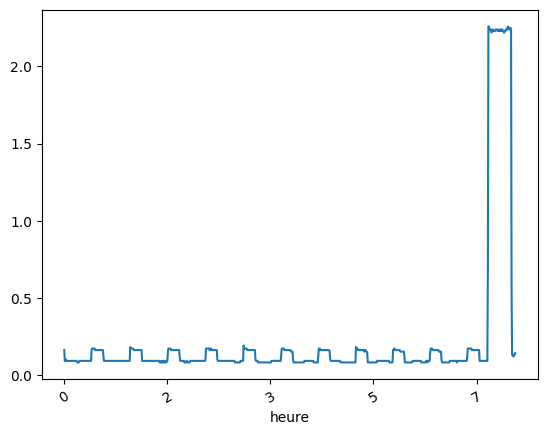

In [882]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [883]:
end = time.time()
print(end - start)

20.910912036895752


### grouped by 'heure'

In [884]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 999124 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   876 non-null    int64         
 1   kWh        876 non-null    float64       
 2   sec        876 non-null    float64       
 3   Wh         876 non-null    float64       
 4   cumul(ms)  876 non-null    int64         
 5   dates      876 non-null    datetime64[ns]
 6   days       876 non-null    object        
 7   heure      876 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 61.6+ KB


In [885]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999124,22656,0.16,22.656,158.898305,26929639469,2025-07-04 00:00:11.016871,04/07/25
999125,37942,0.09,37.942,94.881661,26929677411,2025-07-04 00:00:48.958871,04/07/25
999126,37391,0.10,37.391,96.279853,26929714802,2025-07-04 00:01:26.349871,04/07/25
999127,37067,0.10,37.067,97.121429,26929751869,2025-07-04 00:02:03.416871,04/07/25
999128,39118,0.09,39.118,92.029245,26929790987,2025-07-04 00:02:42.534871,04/07/25
...,...,...,...,...,...,...,...
999995,28700,0.12,28.700,125.435540,26959082858,2025-07-04 08:10:54.405871,04/07/25
999996,29674,0.12,29.674,121.318326,26959112532,2025-07-04 08:11:24.079871,04/07/25
999997,28220,0.13,28.220,127.569100,26959140752,2025-07-04 08:11:52.299871,04/07/25
999998,27532,0.13,27.532,130.756937,26959168284,2025-07-04 08:12:19.831871,04/07/25


In [886]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [887]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     99
1     99
2    108
3     97
4    103
5    100
6     95
7    108
8     67
Name: kWh, dtype: int64

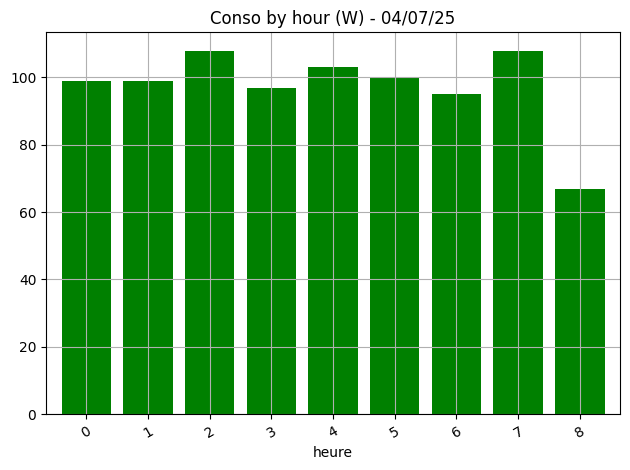

In [888]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [889]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 26/08/24 to 04/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     313 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [890]:
# give the periods of 1 kwh in a day
period()

2025-07-04 00:00:11.016871	2025-07-04 08:12:46.058871	8h 12m 35s 	876


In [891]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [892]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [893]:
df_grp.mean()


kWh    3.194888
dtype: float64

In [894]:
df_grp.head()


,kWh
days,
26/08/24,2.448
27/08/24,3.936
28/08/24,3.760
29/08/24,4.045
30/08/24,3.603


In [895]:
df_grp.tail()


,kWh
days,
30/06/25,2.774
01/07/25,3.653
02/07/25,3.187
03/07/25,2.554
04/07/25,0.876


In [896]:
end = time.time()
print(end - start)

21.849793672561646


# plot les 100 derniers jours


In [897]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.00613
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

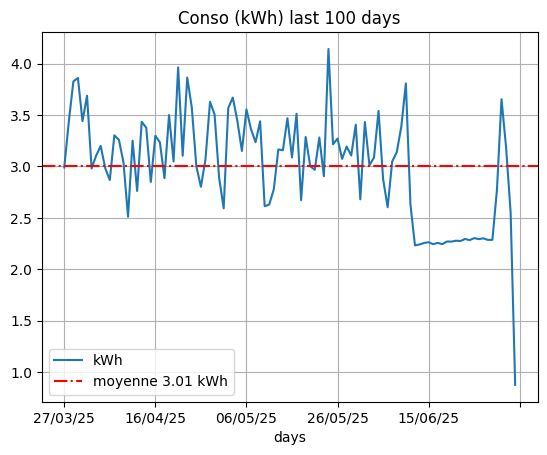

In [898]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [899]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,0.876
max,4.142


In [900]:
end = time.time()
print(end - start)

22.324610233306885


In [901]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('04/06/25', '29/06/25')

In [902]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.602633
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

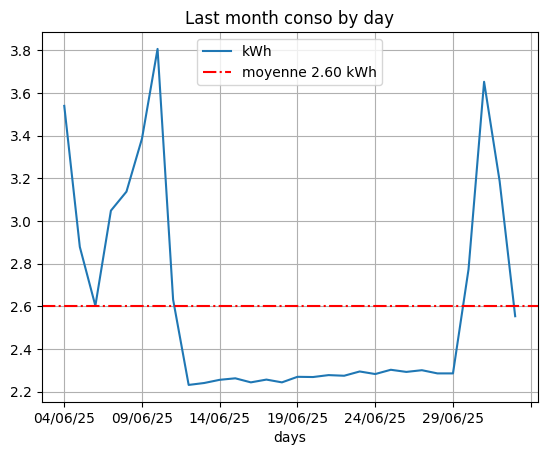

In [903]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [904]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 10/06/25 3.807
Min : 12/06/25 2.232


# Temps de conso par tranche de 1 kWh

In [905]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


1
2025-07-04 00:00:11.016871	2025-07-04 08:12:46.058871	8h 12m 35s 	876


In [906]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('08:13:00', 0.876, 876)

In [907]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 999124 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   876 non-null    int64         
 1   kWh        876 non-null    float64       
 2   sec        876 non-null    float64       
 3   Wh         876 non-null    float64       
 4   cumul(ms)  876 non-null    int64         
 5   dates      876 non-null    datetime64[ns]
 6   days       876 non-null    object        
 7   heure      876 non-null    object        
 8   hours      876 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 68.4+ KB


In [908]:
conso_hours['heure'], conso_hours['hours']

(999124    0
 999125    0
 999126    0
 999127    0
 999128    0
          ..
 999995    8
 999996    8
 999997    8
 999998    8
 999999    8
 Name: heure, Length: 876, dtype: object,
 999124    00
 999125    00
 999126    00
 999127    00
 999128    00
           ..
 999995    08
 999996    08
 999997    08
 999998    08
 999999    08
 Name: hours, Length: 876, dtype: object)

In [909]:
end = time.time()
print(end - start)

23.470011949539185


# select number of days to display


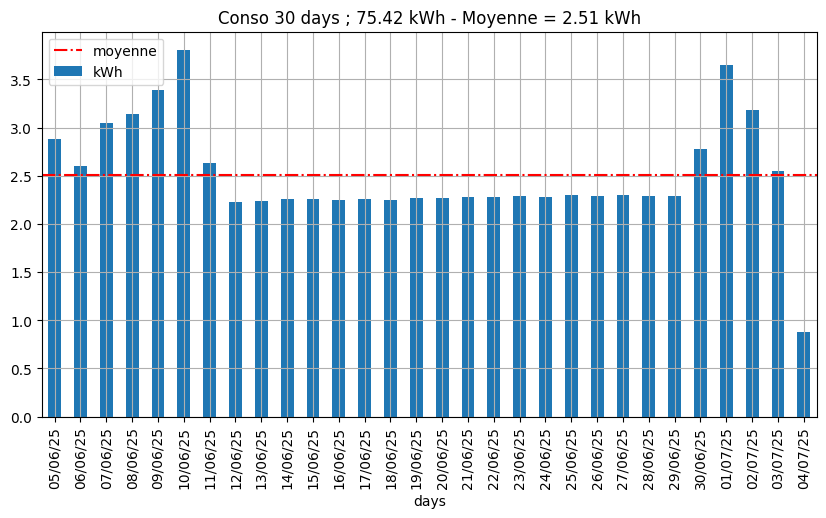

In [910]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


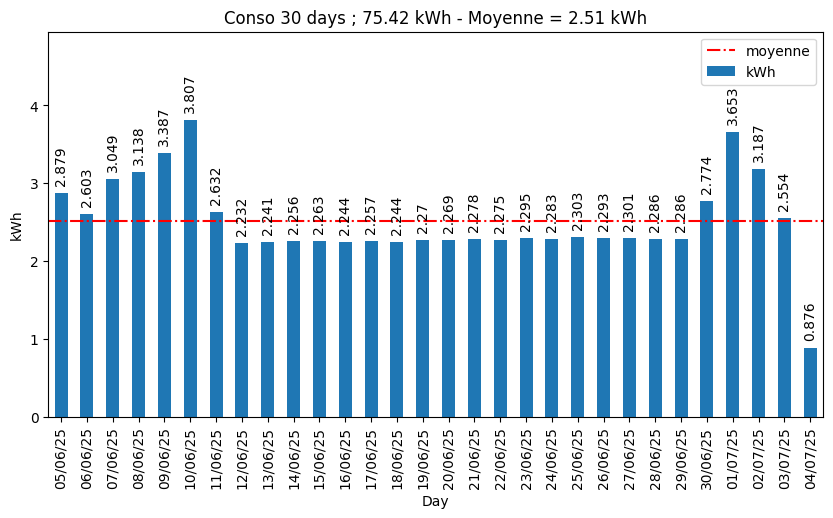

In [911]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [912]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
05/06/25    2.879
06/06/25    2.603
07/06/25    3.049
08/06/25    3.138
09/06/25    3.387
10/06/25    3.807
11/06/25    2.632
12/06/25    2.232
13/06/25    2.241
14/06/25    2.256
15/06/25    2.263
16/06/25    2.244
17/06/25    2.257
18/06/25    2.244
19/06/25    2.270
20/06/25    2.269
21/06/25    2.278
22/06/25    2.275
23/06/25    2.295
24/06/25    2.283
25/06/25    2.303
26/06/25    2.293
27/06/25    2.301
28/06/25    2.286
29/06/25    2.286
30/06/25    2.774
01/07/25    3.653
02/07/25    3.187
03/07/25    2.554
04/07/25    0.876
Name: kWh, dtype: float64

In [913]:
x_labels=df_grp.tail(span).index
x_labels

Index(['05/06/25', '06/06/25', '07/06/25', '08/06/25', '09/06/25', '10/06/25',
       '11/06/25', '12/06/25', '13/06/25', '14/06/25', '15/06/25', '16/06/25',
       '17/06/25', '18/06/25', '19/06/25', '20/06/25', '21/06/25', '22/06/25',
       '23/06/25', '24/06/25', '25/06/25', '26/06/25', '27/06/25', '28/06/25',
       '29/06/25', '30/06/25', '01/07/25', '02/07/25', '03/07/25', '04/07/25'],
      dtype='object', name='days')

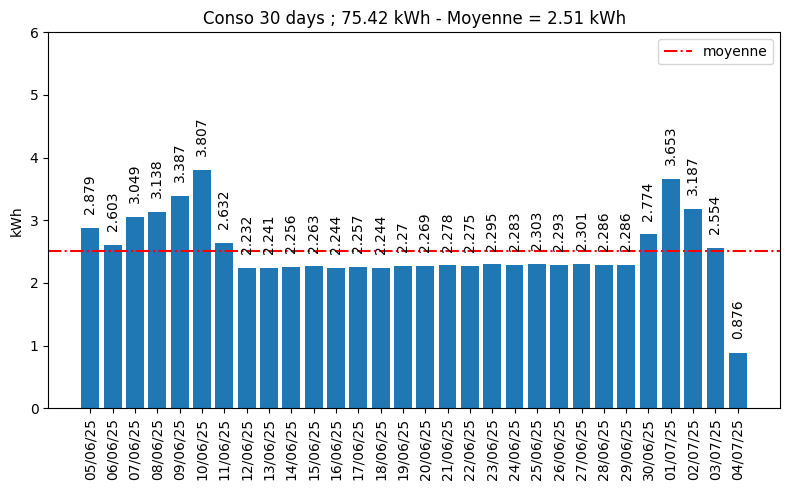

In [914]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [915]:
end = time.time()
print(end - start)

26.617890119552612


In [916]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

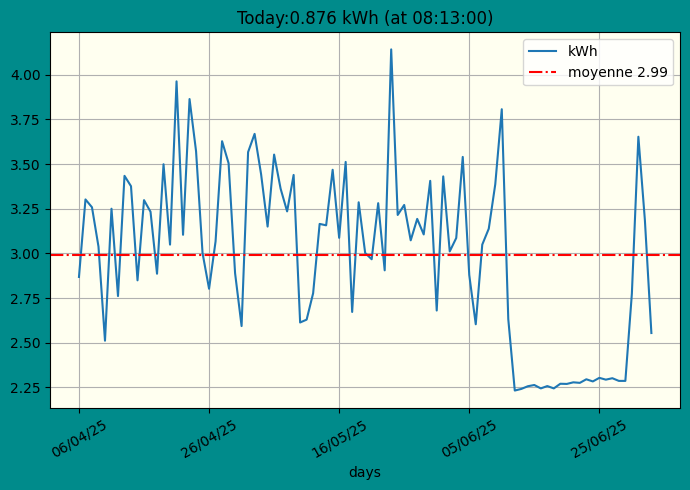

In [917]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

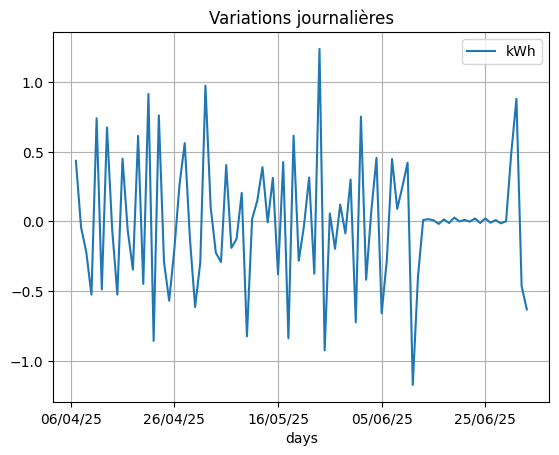

In [918]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [919]:
end = time.time()
print(end - start)

27.49175453186035


# Data from 21/08/23

In [920]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,31296,0.12,31.296,115.030675,31296,2024-08-26 07:33:22.843871,26/08/24,07,2024-08,26
1,32085,0.11,32.085,112.201964,63381,2024-08-26 07:33:54.928871,26/08/24,07,2024-08,26
2,32854,0.11,32.854,109.575699,96235,2024-08-26 07:34:27.782871,26/08/24,07,2024-08,26
3,32819,0.11,32.819,109.692556,129054,2024-08-26 07:35:00.601871,26/08/24,07,2024-08,26
4,32716,0.11,32.716,110.037902,161770,2024-08-26 07:35:33.317871,26/08/24,07,2024-08,26
...,...,...,...,...,...,...,...,...,...,...
999995,28700,0.12,28.700,125.435540,26959082858,2025-07-04 08:10:54.405871,04/07/25,08,2025-07,04
999996,29674,0.12,29.674,121.318326,26959112532,2025-07-04 08:11:24.079871,04/07/25,08,2025-07,04
999997,28220,0.13,28.220,127.569100,26959140752,2025-07-04 08:11:52.299871,04/07/25,08,2025-07,04
999998,27532,0.13,27.532,130.756937,26959168284,2025-07-04 08:12:19.831871,04/07/25,08,2025-07,04


In [921]:
end = time.time()
print(end - start)

59.018649101257324


In [922]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

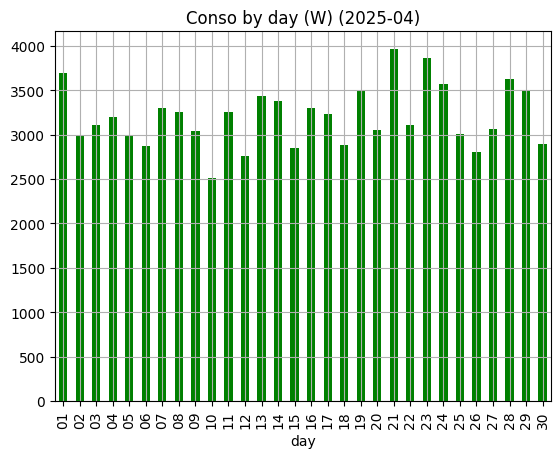

In [923]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [924]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3198.6666666666665)

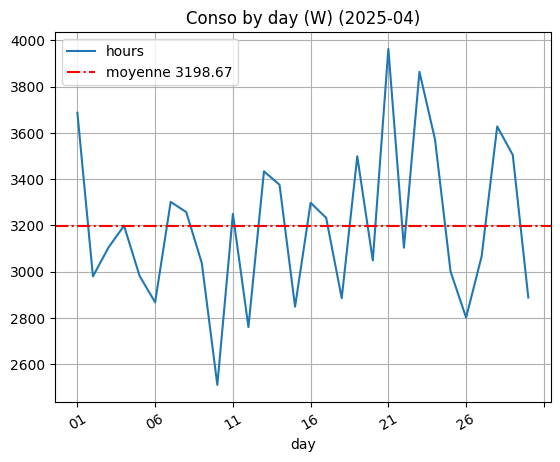

In [925]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [926]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

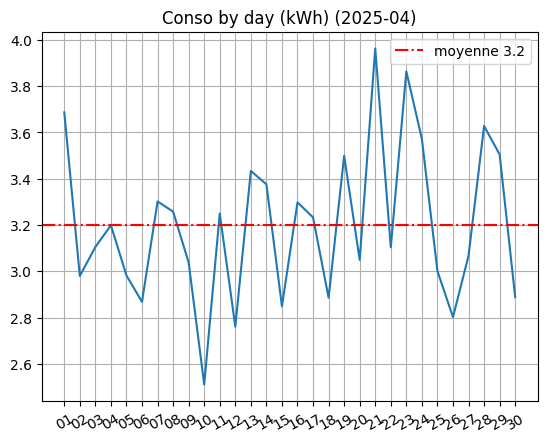

In [927]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [928]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [929]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [930]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,21496,21496,21496
2024-09,69926,69926,69926
2024-10,73348,73348,73348
2024-11,108178,108178,108178
2024-12,113984,113984,113984
2025-01,113852,113852,113852
2025-02,104368,104368,104368
2025-03,111787,111787,111787
2025-04,95960,95960,95960


In [931]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [932]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [933]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
26/08/24,2448
27/08/24,3936
28/08/24,3760
29/08/24,4045
30/08/24,3603
...,...
30/06/25,2774
01/07/25,3653
02/07/25,3187


In [934]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,31296,0.12,31.296,115.030675,31296,2024-08-26 07:33:22.843871,26/08/24,07,2024-08,26
1,32085,0.11,32.085,112.201964,63381,2024-08-26 07:33:54.928871,26/08/24,07,2024-08,26
2,32854,0.11,32.854,109.575699,96235,2024-08-26 07:34:27.782871,26/08/24,07,2024-08,26
3,32819,0.11,32.819,109.692556,129054,2024-08-26 07:35:00.601871,26/08/24,07,2024-08,26
4,32716,0.11,32.716,110.037902,161770,2024-08-26 07:35:33.317871,26/08/24,07,2024-08,26
...,...,...,...,...,...,...,...,...,...,...
999995,28700,0.12,28.700,125.435540,26959082858,2025-07-04 08:10:54.405871,04/07/25,08,2025-07,04
999996,29674,0.12,29.674,121.318326,26959112532,2025-07-04 08:11:24.079871,04/07/25,08,2025-07,04
999997,28220,0.13,28.220,127.569100,26959140752,2025-07-04 08:11:52.299871,04/07/25,08,2025-07,04
999998,27532,0.13,27.532,130.756937,26959168284,2025-07-04 08:12:19.831871,04/07/25,08,2025-07,04


In [935]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
26/08/24 07    0       26/08/24    07  0.12
               1       26/08/24    07  0.11
               2       26/08/24    07  0.11
               3       26/08/24    07  0.11
               4       26/08/24    07  0.11
...                         ...   ...   ...
04/07/25 08    999995  04/07/25    08  0.12
               999996  04/07/25    08  0.12
               999997  04/07/25    08  0.13
               999998  04/07/25    08  0.13
               999999  04/07/25    08  0.14

[1000000 rows x 3 columns]

In [936]:
groupallbyday.indices.keys()

dict_keys(['26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/1

In [937]:
groupallbydayhours.indices.keys()

dict_keys([('26/08/24', '07'), ('26/08/24', '08'), ('26/08/24', '09'), ('26/08/24', '10'), ('26/08/24', '11'), ('26/08/24', '12'), ('26/08/24', '13'), ('26/08/24', '14'), ('26/08/24', '15'), ('26/08/24', '16'), ('26/08/24', '17'), ('26/08/24', '18'), ('26/08/24', '19'), ('26/08/24', '20'), ('26/08/24', '21'), ('26/08/24', '22'), ('26/08/24', '23'), ('27/08/24', '07'), ('27/08/24', '08'), ('27/08/24', '09'), ('27/08/24', '10'), ('27/08/24', '11'), ('27/08/24', '12'), ('27/08/24', '13'), ('27/08/24', '14'), ('27/08/24', '15'), ('27/08/24', '16'), ('27/08/24', '17'), ('27/08/24', '18'), ('27/08/24', '19'), ('27/08/24', '20'), ('27/08/24', '21'), ('27/08/24', '22'), ('27/08/24', '23'), ('27/08/24', '00'), ('27/08/24', '01'), ('27/08/24', '02'), ('27/08/24', '03'), ('27/08/24', '04'), ('27/08/24', '05'), ('27/08/24', '06'), ('28/08/24', '07'), ('28/08/24', '08'), ('28/08/24', '09'), ('28/08/24', '10'), ('28/08/24', '11'), ('28/08/24', '12'), ('28/08/24', '13'), ('28/08/24', '14'), ('28/08/2

In [938]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
26/08/24,2448,2448
27/08/24,3936,3936
28/08/24,3760,3760
29/08/24,4045,4045
30/08/24,3603,3603
...,...,...
30/06/25,2774,2774
01/07/25,3653,3653
02/07/25,3187,3187


In [939]:
grp_by_day['kWh'].cumsum()

days
26/08/24       2448
27/08/24       6384
28/08/24      10144
29/08/24      14189
30/08/24      17792
             ...   
30/06/25     989730
01/07/25     993383
02/07/25     996570
03/07/25     999124
04/07/25    1000000
Name: kWh, Length: 313, dtype: int64

In [940]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
26/08/24 07      61
         08     122
         09     124
         10     121
         11     119
...             ...
04/07/25 04     103
         05     100
         06      95
         07     108
         08      67

[7490 rows x 1 columns]

In [941]:
grp_by_dayhours['kWh'].cumsum()

days      hours
26/08/24  07            61
          08           183
          09           307
          10           428
          11           547
                    ...   
04/07/25  04        999630
          05        999730
          06        999825
          07        999933
          08       1000000
Name: kWh, Length: 7490, dtype: int64

In [942]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
26/08/24 07      61      61   NaN
         08     122     183  61.0
         09     124     307   2.0
         10     121     428  -3.0
         11     119     547  -2.0
...             ...     ...   ...
04/07/25 04     103     506   6.0
         05     100     606  -3.0
         06      95     701  -5.0
         07     108     809  13.0
         08      67     876 -41.0

[7490 rows x 3 columns]

In [943]:
today, grp_by_dayhours.loc[today]

('04/07/25',
        kWh  cumsum  diff
 hours                   
 00      99      99   NaN
 01      99     198   0.0
 02     108     306   9.0
 03      97     403 -11.0
 04     103     506   6.0
 05     100     606  -3.0
 06      95     701  -5.0
 07     108     809  13.0
 08      67     876 -41.0)

Text(0.5, 1.0, 'Cumul journalier')

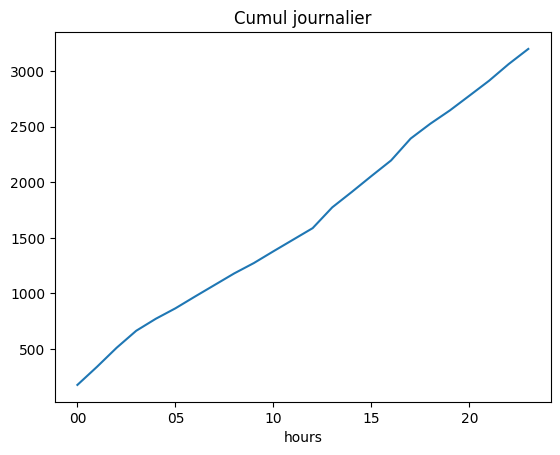

In [944]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

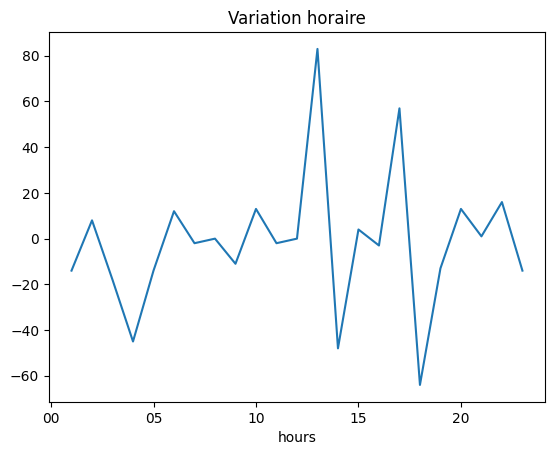

In [945]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [946]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

313

In [947]:
df_grp.tail(n)['kWh'].describe()


count    313.000000
mean       3.194888
std        0.746203
min        0.876000
25%        2.868000
50%        3.376000
75%        3.685000
max        4.740000
Name: kWh, dtype: float64

In [948]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [949]:
n, np.nanmean(df_grp.tail(n))

(313, np.float64(3.194888178913738))

Text(0.5, 1.0, '313 days')

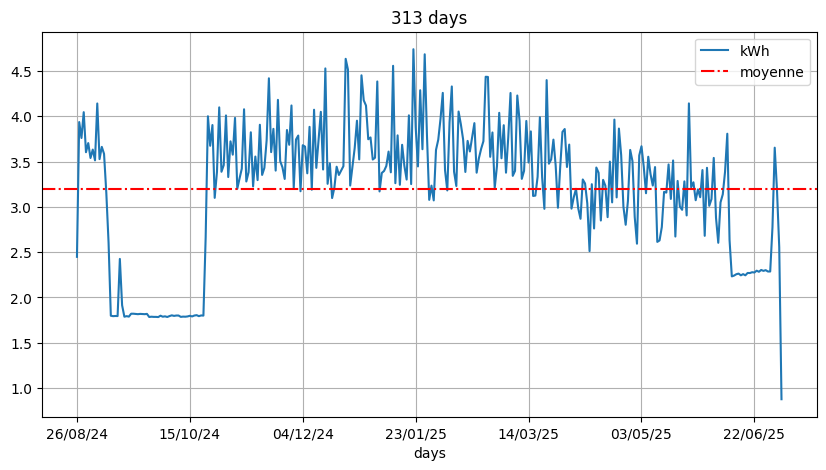

In [950]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

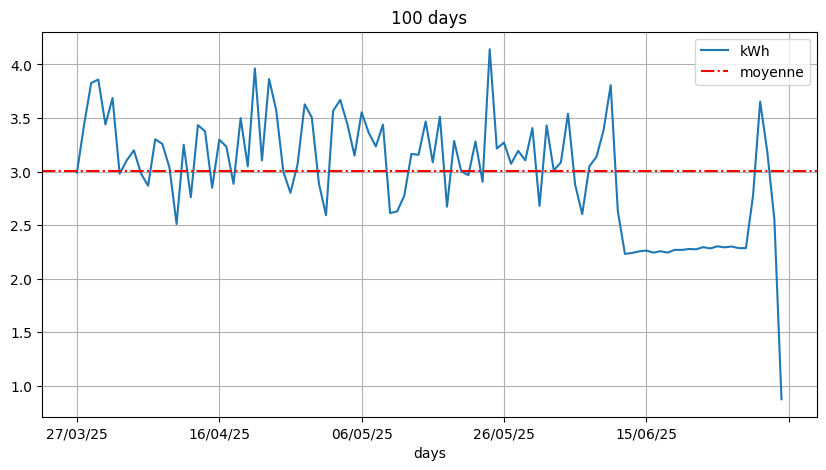

In [951]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [952]:
np.nanmean(df_grp.tail(span))

np.float64(3.00613)

In [953]:
df_grp['kWh']

days
26/08/24    2.448
27/08/24    3.936
28/08/24    3.760
29/08/24    4.045
30/08/24    3.603
            ...  
30/06/25    2.774
01/07/25    3.653
02/07/25    3.187
03/07/25    2.554
04/07/25    0.876
Name: kWh, Length: 313, dtype: float64

In [954]:
df_grp.describe()

,kWh
count,313.000000
mean,3.194888
std,0.746203
min,0.876000
25%,2.868000
50%,3.376000
75%,3.685000
max,4.740000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

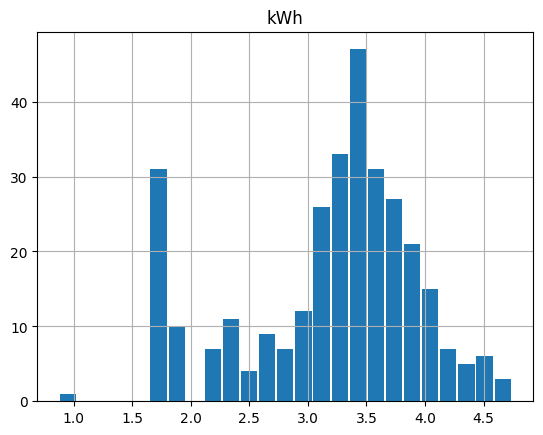

In [955]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [956]:
df_grp.tail(span)['kWh']

days
27/03/25    2.990
28/03/25    3.436
29/03/25    3.827
30/03/25    3.859
31/03/25    3.440
            ...  
30/06/25    2.774
01/07/25    3.653
02/07/25    3.187
03/07/25    2.554
04/07/25    0.876
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [957]:
day

'04/07/25'

In [958]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,99,99,NaN
01,99,198,0.0
02,108,306,9.0
03,97,403,-11.0
04,103,506,6.0
05,100,606,-3.0
06,95,701,-5.0
07,108,809,13.0
08,67,876,-41.0


In [959]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


9

In [960]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 10)

In [961]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [962]:
grp_by_dayhours.loc[day,'days'].values

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [963]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [964]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [965]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 00 to 08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     9 non-null      int64  
 1   cumsum  9 non-null      int64  
 2   diff    8 non-null      float64
 3   days    9 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 360.0+ bytes


In [966]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [967]:
day

'04/07/25'

In [968]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,99,99,NaN,1.0
01,99,198,0.0,2.0
02,108,306,9.0,3.0
03,97,403,-11.0,4.0
04,103,506,6.0,5.0
05,100,606,-3.0,6.0
06,95,701,-5.0,7.0
07,108,809,13.0,8.0
08,67,876,-41.0,9.0


In [969]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_6040\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(0.8760000000000001)

In [970]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
26/08/24 07      61      61   NaN   NaN
         08     122     183  61.0   NaN
         09     124     307   2.0   NaN
         10     121     428  -3.0   NaN
         11     119     547  -2.0   NaN
...             ...     ...   ...   ...
04/07/25 04     103     506   6.0   5.0
         05     100     606  -3.0   6.0
         06      95     701  -5.0   7.0
         07     108     809  13.0   8.0
         08      67     876 -41.0   9.0

[7490 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '04/07/25: kWh    0.876\ndtype: float64')

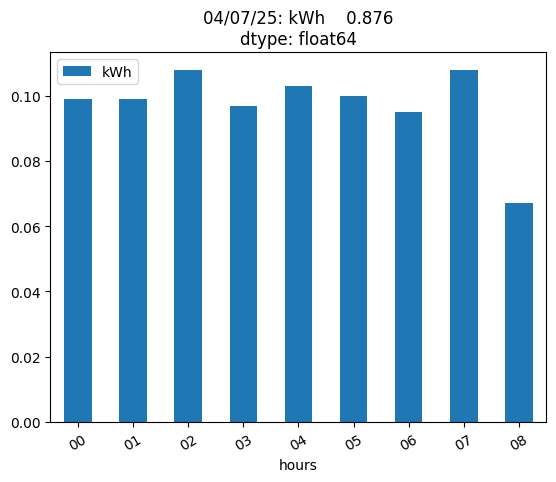

In [971]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [972]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08'], dtype='object', name='hours')

# Conso du jour


In [973]:
grp_by_dayhours.count()

kWh       7490
cumsum    7490
diff      7177
days         9
dtype: int64

'22/01/25'

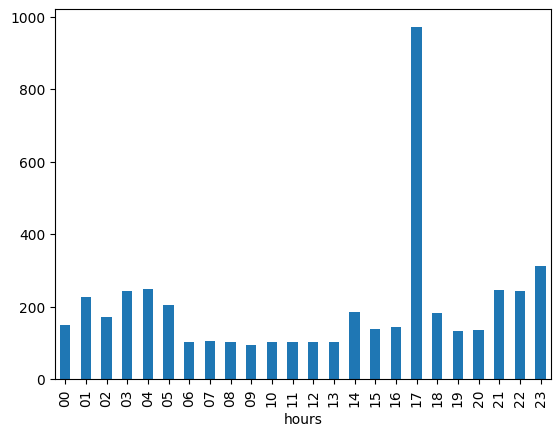

In [974]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [975]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 300.613 , Moyenne= 3.00613


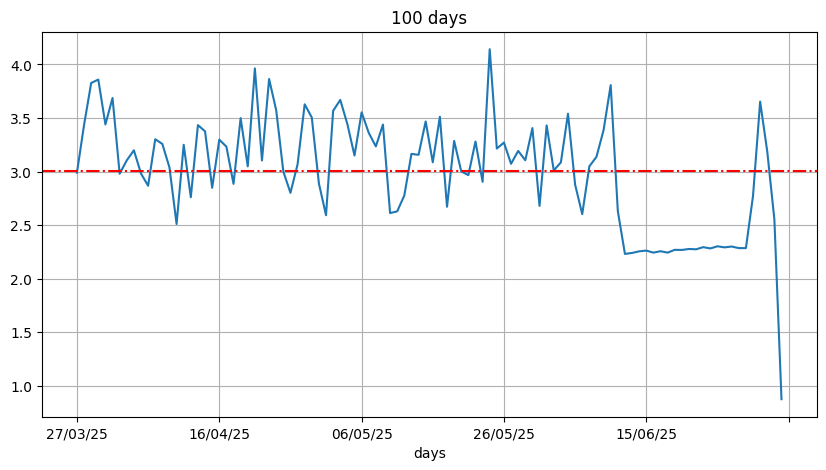

In [976]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [977]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 08:13:52, Minutes in day: 493


In [978]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [979]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:10.12


In [980]:
end - start

70.11762070655823

In [981]:
#df = conso_day
show_tranches()

1
2025-07-04 00:00:11.016871	2025-07-04 08:12:46.058871	8h 12m 35s 	876


In [982]:
df_grp.tail(7)['kWh']

days
28/06/25    2.286
29/06/25    2.286
30/06/25    2.774
01/07/25    3.653
02/07/25    3.187
03/07/25    2.554
04/07/25    0.876
Name: kWh, dtype: float64

<Axes: xlabel='days'>

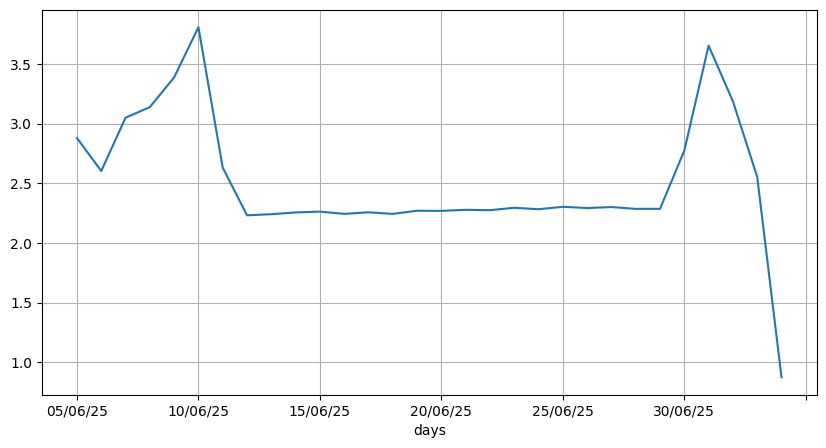

In [983]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

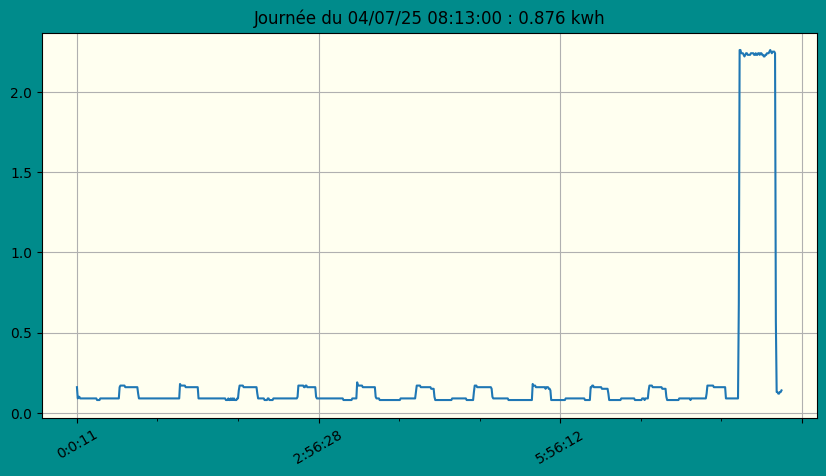

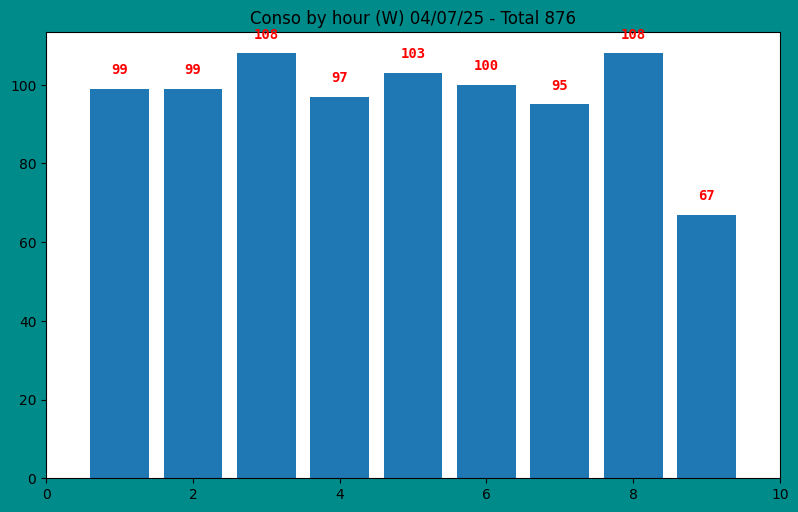

In [984]:
show(today,bgcolor='ivory')
conso_by_hour(today)

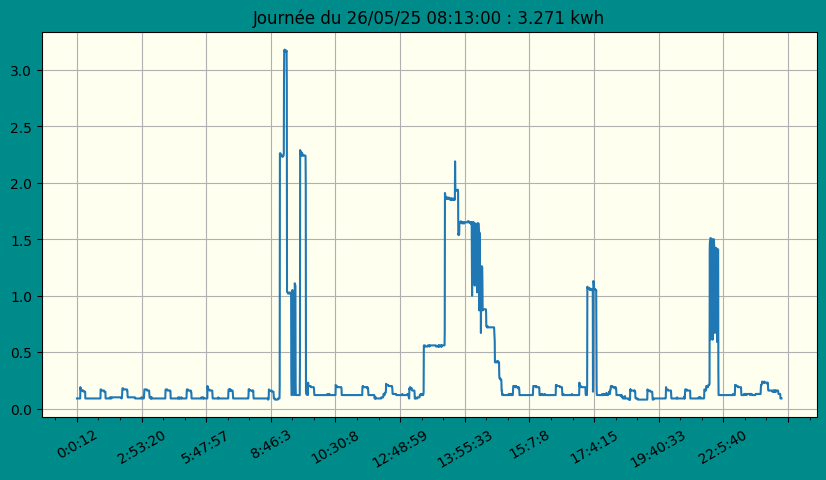

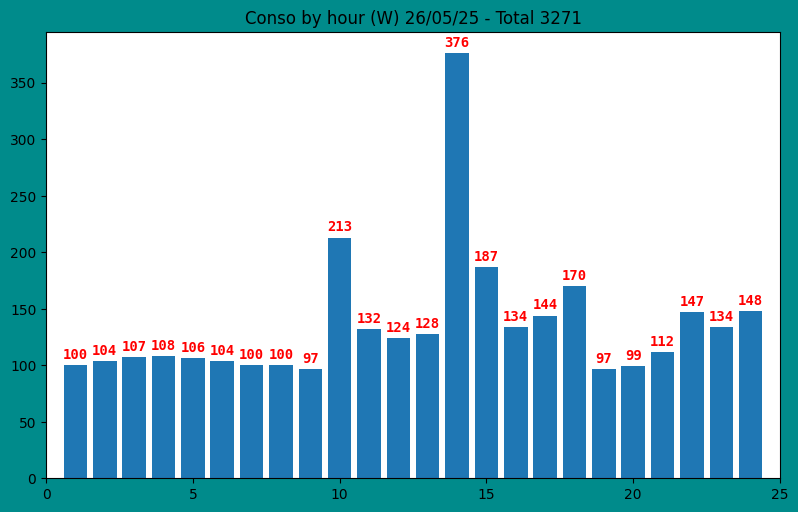

In [985]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4740)

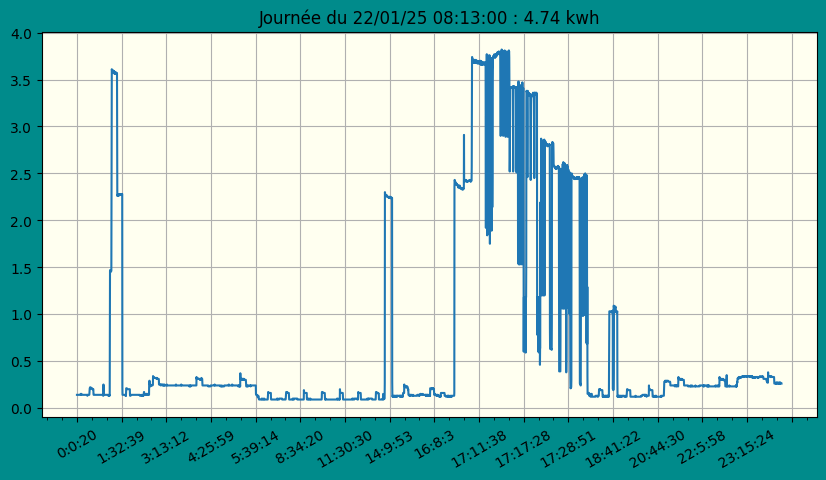

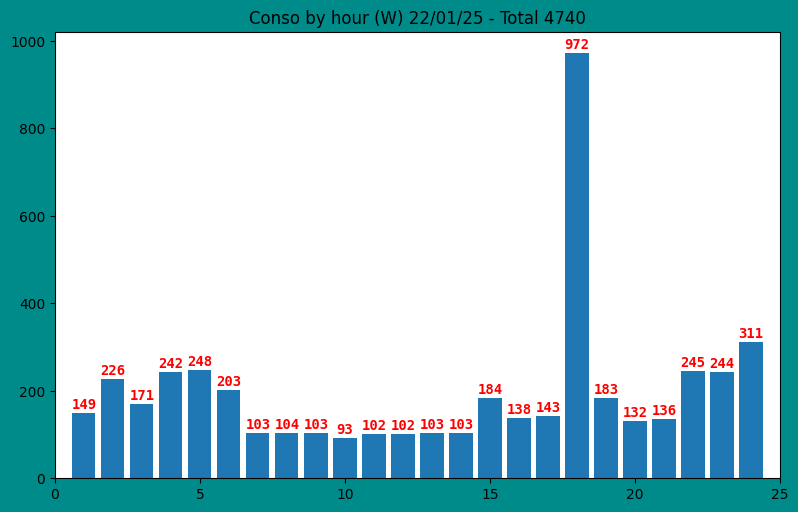

In [986]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

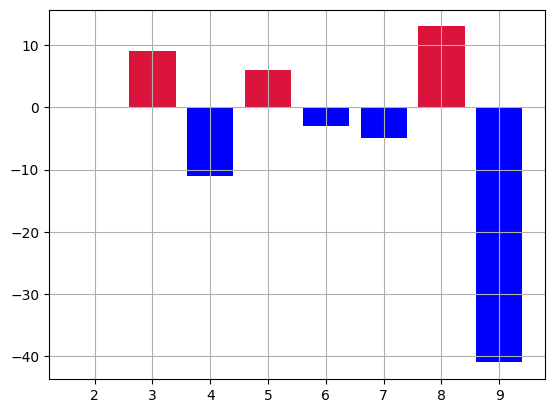

In [987]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

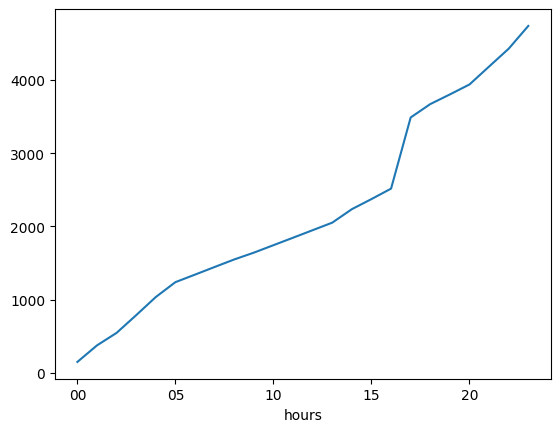

In [988]:
data.cumsum().plot()


<Axes: xlabel='hours'>

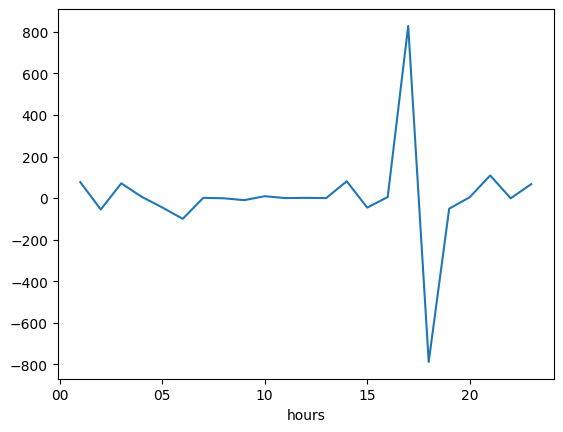

In [989]:
# evolution par heure
data.diff().plot()

In [990]:
data.diff().describe()

count     23.000000
mean       7.043478
std      248.865695
min     -789.000000
25%      -27.500000
50%        1.000000
75%       38.000000
max      829.000000
Name: kWh, dtype: float64

<Axes: >

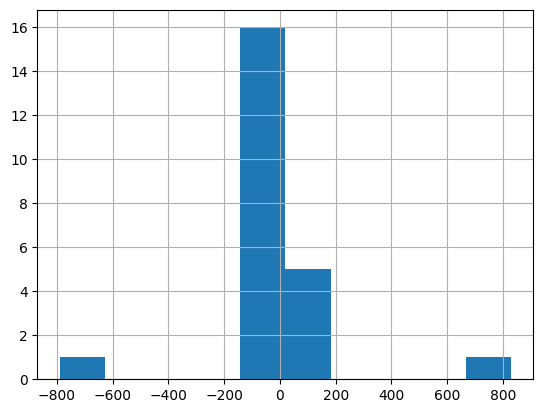

In [991]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [992]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [993]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

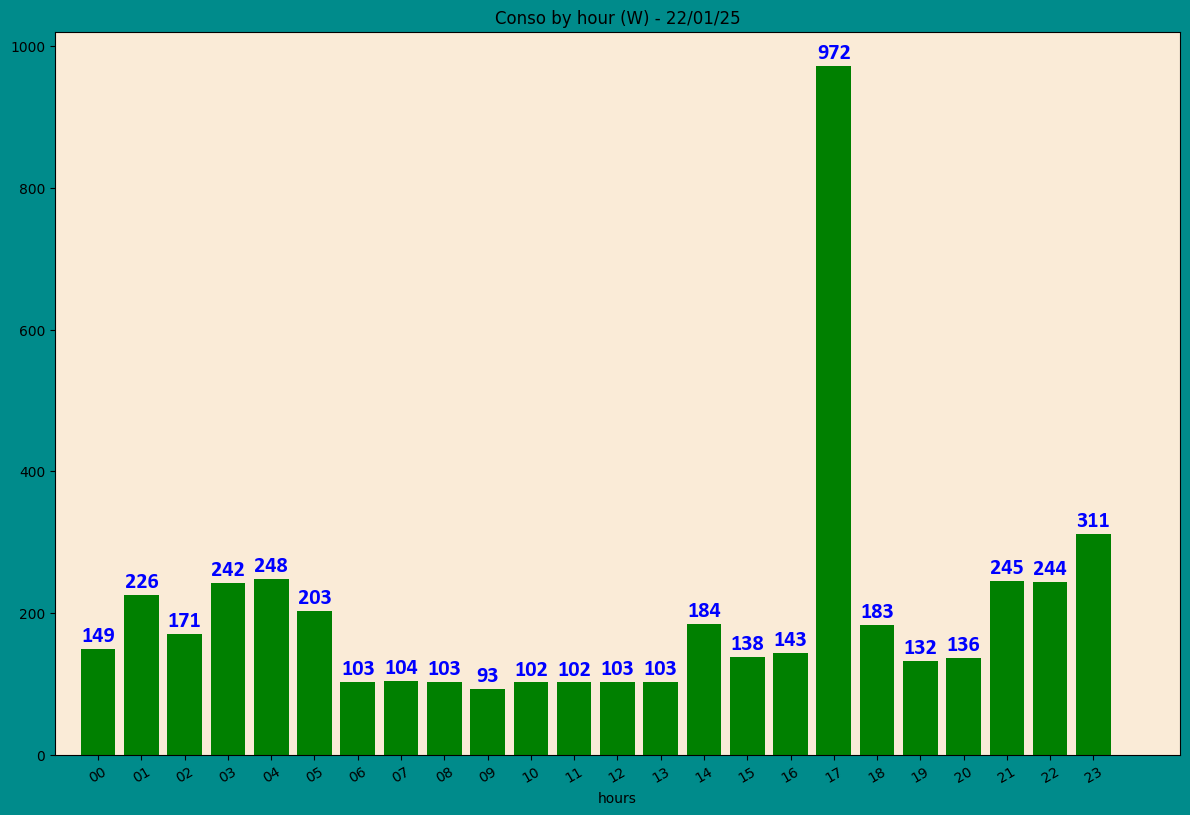

In [994]:
day,conso_byhour(day)

In [995]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


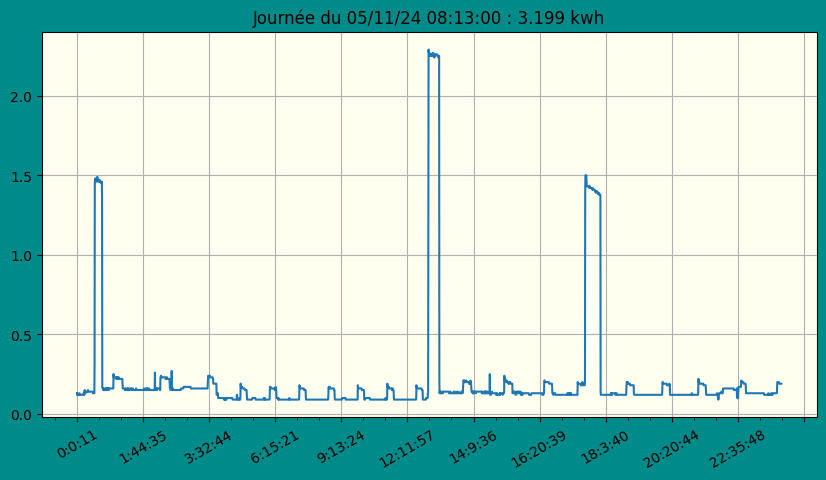

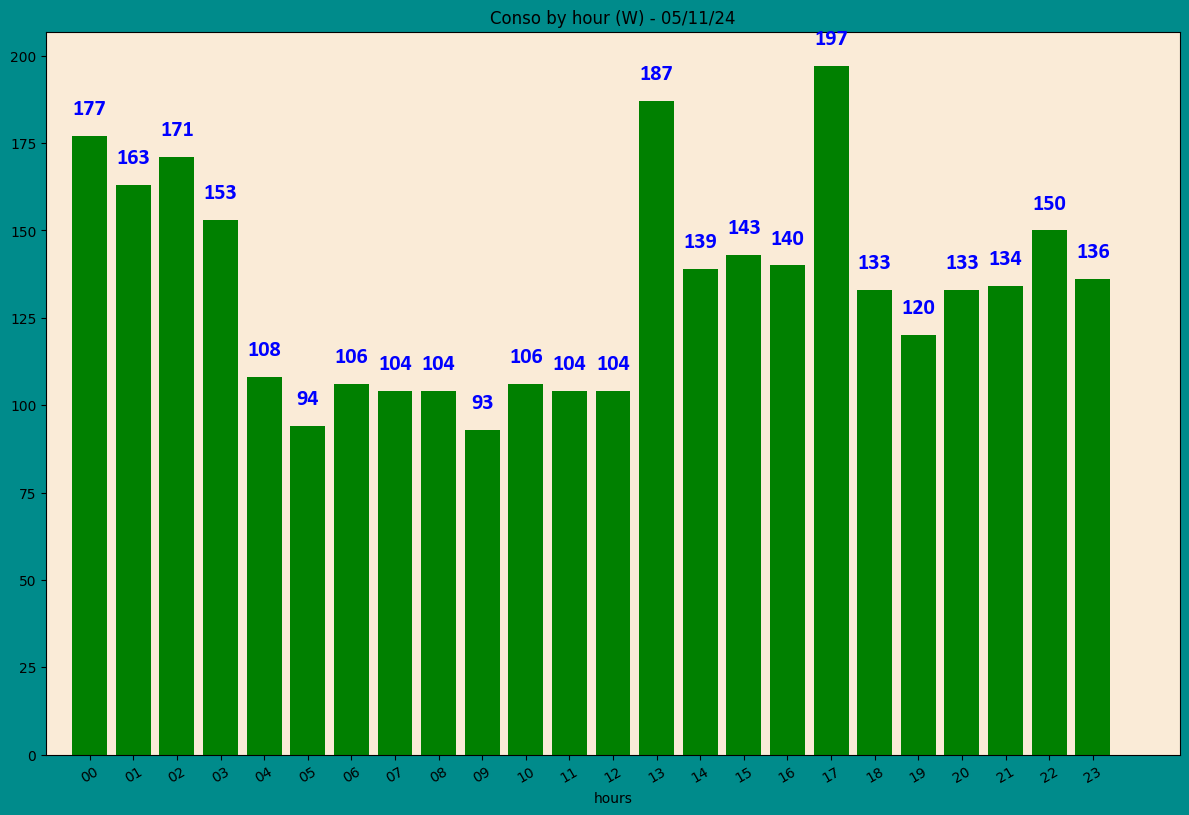

In [996]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [997]:
month

,day,hours,months,kWh
716939,01,00,2025-04,0.27
716940,01,00,2025-04,0.27
716941,01,00,2025-04,0.27
716942,01,00,2025-04,0.27
716943,01,00,2025-04,0.27
...,...,...,...,...
812894,30,23,2025-04,0.09
812895,30,23,2025-04,0.09
812896,30,23,2025-04,0.09
812897,30,23,2025-04,0.09


In [998]:
month.describe()


,kWh
count,95960.000000
mean,0.310171
std,0.547498
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

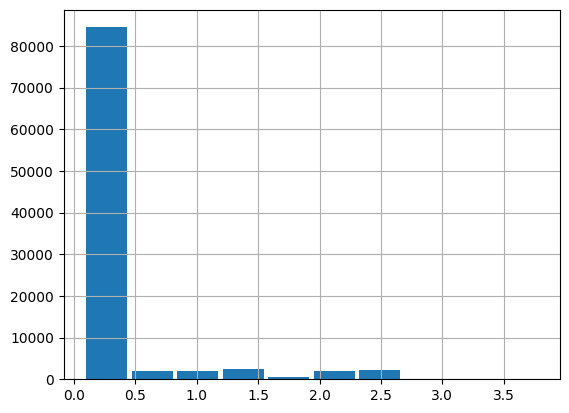

In [999]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

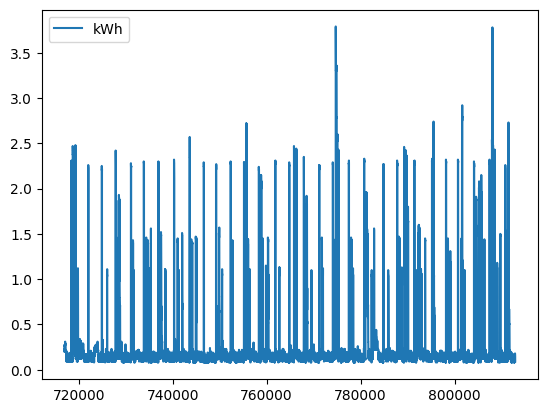

In [1000]:
month.plot()

In [1001]:
# index with max conso in this month
month.idxmax().kWh

np.int64(774709)

In [1002]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       810010
hours     720450
months    716939
kWh       774709
dtype: int64

In [1003]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1004]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
26/08/24 07      61      61   NaN   NaN
         08     122     183  61.0   NaN
         09     124     307   2.0   NaN
         10     121     428  -3.0   NaN
         11     119     547  -2.0   NaN
...             ...     ...   ...   ...
04/07/25 04     103     506   6.0   5.0
         05     100     606  -3.0   6.0
         06      95     701  -5.0   7.0
         07     108     809  13.0   8.0
         08      67     876 -41.0   9.0

[7490 rows x 4 columns]

In [1005]:
month

,day,hours,months,kWh
716939,01,00,2025-04,0.27
716940,01,00,2025-04,0.27
716941,01,00,2025-04,0.27
716942,01,00,2025-04,0.27
716943,01,00,2025-04,0.27
...,...,...,...,...
812894,30,23,2025-04,0.09
812895,30,23,2025-04,0.09
812896,30,23,2025-04,0.09
812897,30,23,2025-04,0.09


In [1006]:
month.idxmax()


day       810010
hours     720450
months    716939
kWh       774709
dtype: int64

In [1007]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 774709, dtype: object

In [1008]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       165
          01       182
          02       156
          03       116
          04       100
          05       110
          06       111
          07       111
          08        98
          09       110
          10       110
          11       110
          12       170
          13       145
          14       148
          15       146
          16       188
          17       146
          18       197
          19       157
          20       150
          21       143
          22       157
          23       225
Name: kWh, dtype: int64

In [1009]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'23'

<Axes: xlabel='days,hours'>

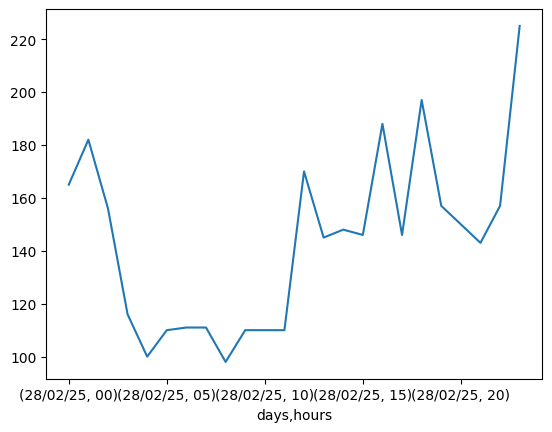

In [1010]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1011]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1012]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1013]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1014]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB